In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import io, transform, img_as_float
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models
from torch.autograd import Variable
import time
import random
import matplotlib.cm as cm
import itertools
import matplotlib._color_data as mcd


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


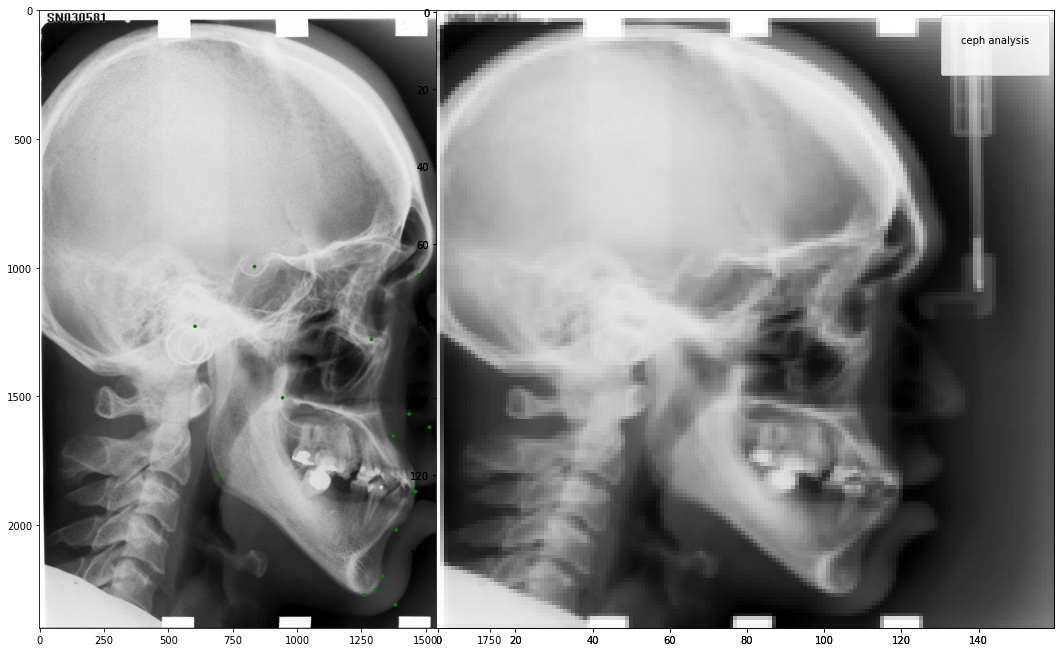

In [6]:
SAMPLE_PATH = r"train/001.jpg"
TXT_PATH = r"train/001.txt"

img = io.imread(SAMPLE_PATH, as_gray=True)

def extract_labels_from_txt(path):
    with open(path, "r") as f:
        coords_raw = f.readlines()[:18]
        coords_raw = [tuple([int(float(s)) for s in t.split(",")]) for t in coords_raw]
        return coords_raw

coords_raw = extract_labels_from_txt(TXT_PATH)

plt.rcParams["figure.figsize"] = [30,25]
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 1, 1)
ax3 = fig.add_subplot(2, 1, 1)
ax1.imshow(img, cmap="gray")
orig_y, orig_x = img.shape[:2]
SCALE = 15


rescaled_img = transform.resize(img,(orig_y/SCALE,orig_y/SCALE))
ax2.imshow(rescaled_img, cmap="gray")
ax3.imshow(rescaled_img, cmap="gray")

colors = itertools.cycle(['b', 'g', 'y', 'r',
                      'violet', 'tomato', 'teal', 'tan', 'silver', 'purple',
                      'pink', 'orchid', 'orangered', 'orange', 'olive', 'magenta', 'lime', 'fuchsia'])
points = itertools.cycle(["Sella", "Nasion", "Porion","Orbitale","Pterygomaxillary Assure","Condylion","Articulare","Posterior nasal spine","Anterior nasal spine","A-point","B-point","Pogonion","Gonion","Gnathion","Menton"])
for c in coords_raw:
   
    x,y = c
    x = int(x*(orig_y*1.0/orig_x)/SCALE)
    y = int(y/SCALE)
    ax1.add_patch(plt.Circle(c, 5, color='g')) 
    ax2.add_patch(plt.Circle((x,y), 1, color=next(colors), label=next(points))) 
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='ceph analysis', borderpad=2) 
plt.show()

In [7]:
#CNN Network 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=5),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(24, 36, kernel_size=3),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(36, 48, kernel_size=3),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear(18*18*48, 18*18*48),
            nn.BatchNorm1d(18*18*48),
            nn.ReLU(),
            nn.Linear(18*18*48, 18*48),
            nn.BatchNorm1d(18*48),
            nn.ReLU(),
            nn.Linear(18*48, 18*2))
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 

class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=3),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            
            nn.Conv2d(24, 36, kernel_size=4),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            
            nn.Conv2d(36, 48, kernel_size=3),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(48, 72, kernel_size=3),
            nn.BatchNorm2d(72),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8*8*72, 8*8*72),
            nn.BatchNorm1d(8*8*72),
            nn.ReLU(),
            nn.Linear(8*8*72, 18*2))
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 


In [8]:
# Hyperparams
num_epochs = 5
batch_size = 10  # better accuracy and to avoid memory overload 
learning_rate = 0.001


def optimizer(test_net, train_loader, num_epochs):   # we use Adame Optimizer 
    start_time = time.time()
    epoch_data = []
    loss_data = []
    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(test_net.parameters(), lr=learning_rate)
    # Train the Model
    for epoch in range(num_epochs):
        epoch_time = time.time()
        for i, (data, target) in enumerate(train_loader):
            vd = Variable(data)
            td = Variable(target)

            # Forward + Backward + Optimize
            optimizer.zero_grad()

            outputs = test_net(vd)
            loss = criterion(outputs, td)
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                # for plotting, append epoch and loss data to timeseries:
                epoch_data.append(epoch+1+(i+1)/10.0) # epochs as 1, 1.5, 2.0 etc
                loss_data.append(loss.data[0])
                # print updates:
                print ("Epoch [{}/{}], Iter [{}/{}] Loss: {}, CPU seconds: {}".format(epoch+1, num_epochs, i+1, 
                                                    len(train)//batch_size, loss.data[0], time.time()-epoch_time))
    print("total time elapsed: {}".format(time.time()-start_time))
    plt.plot(epoch_data, loss_data)
    plt.ylabel('loss over time')
    plt.xlabel('training epoch')
    plt.show()
    #####
 
 

In [33]:
BASE_AUG_PATH = r"./train"
def prep_train_loader(img_path):
    data = []
    target = []
    for i, fi in enumerate(os.listdir(img_path)):
        if fi.endswith(".jpg"):
            loop_img = io.imread( fi[:-4]+".jpg", as_gray=True)
            lf = fi[:-4] + ".txt"
            loop_labels = extract_labels_from_txt(lf)
            loop_labels = (np.array(loop_labels) - 80.0)/80.0
            data.append(torch.from_numpy(loop_img).float())
            target.append(torch.from_numpy(loop_labels).float())
    x=np.stack(data)
    data = torch.from_numpy(x)
    data = torch.unsqueeze(data, 1)
    target = torch.stack(target)

    td = TensorDataset(data, target)
    tl = DataLoader(td, batch_size=10, shuffle=False)
    return td, tl

In [34]:
train, train_loader = prep_train_loader(BASE_AUG_PATH)

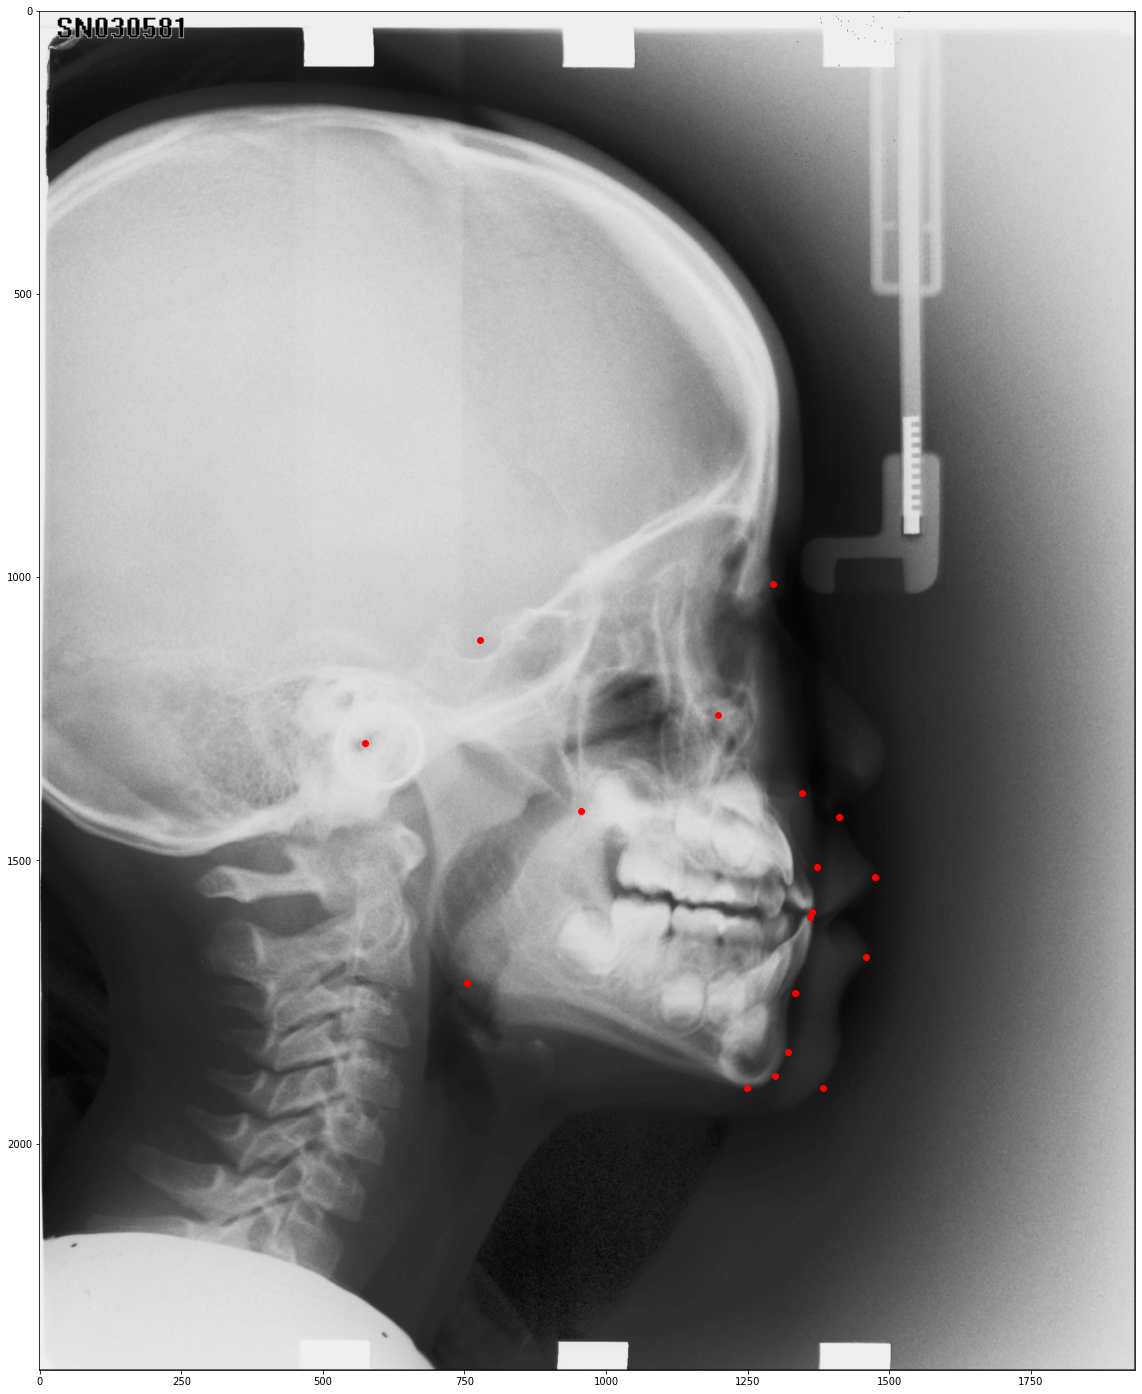

In [40]:
# (optional: make sure image data made it through torchisation intact:)
def plot_sample_tensor(dataset, n):
    sample = dataset[n][0].squeeze()
    sample_labels = dataset[n][1]
    sample_labels = sample_labels * 80 + 80
    sample_labels = [tuple(x) for x in sample_labels]
    plt.imshow(sample, cmap="gray")
    plt.scatter(*zip(*sample_labels), color="r")
    plt.show()
# plot a random image from tensor input:
plot_sample_tensor(train, random.randint(0, len(train)))

In [41]:
data_dir=r"./train"

train, train_loader = prep_train_loader(data_dir)

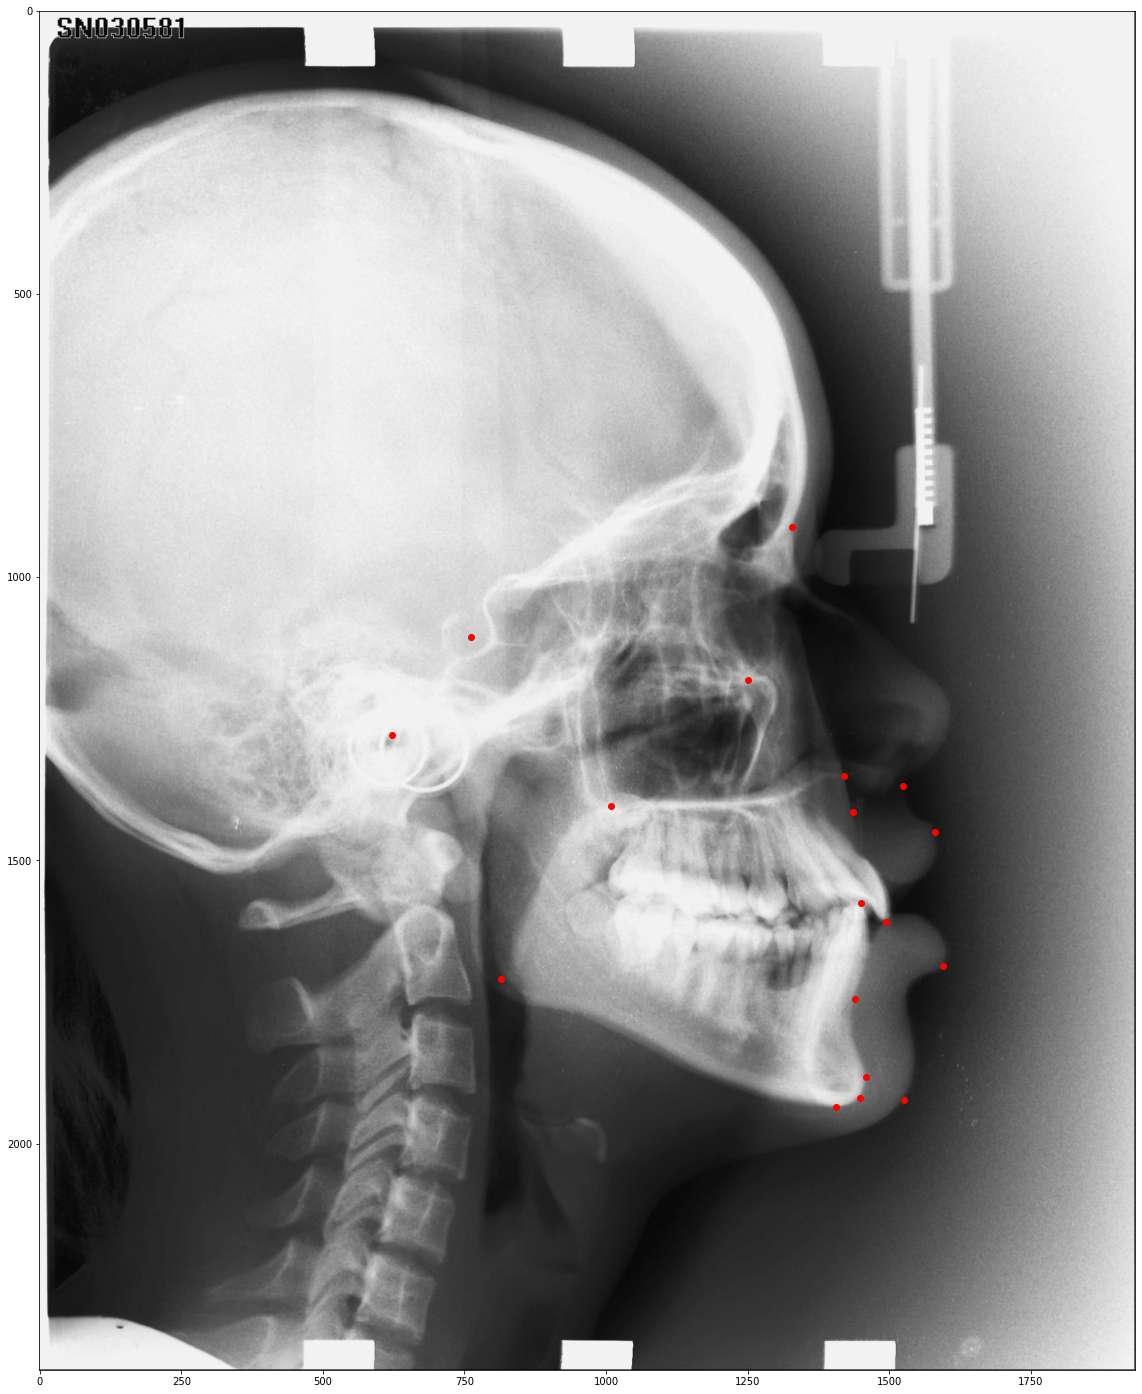

In [42]:
plot_sample_tensor(train,2)

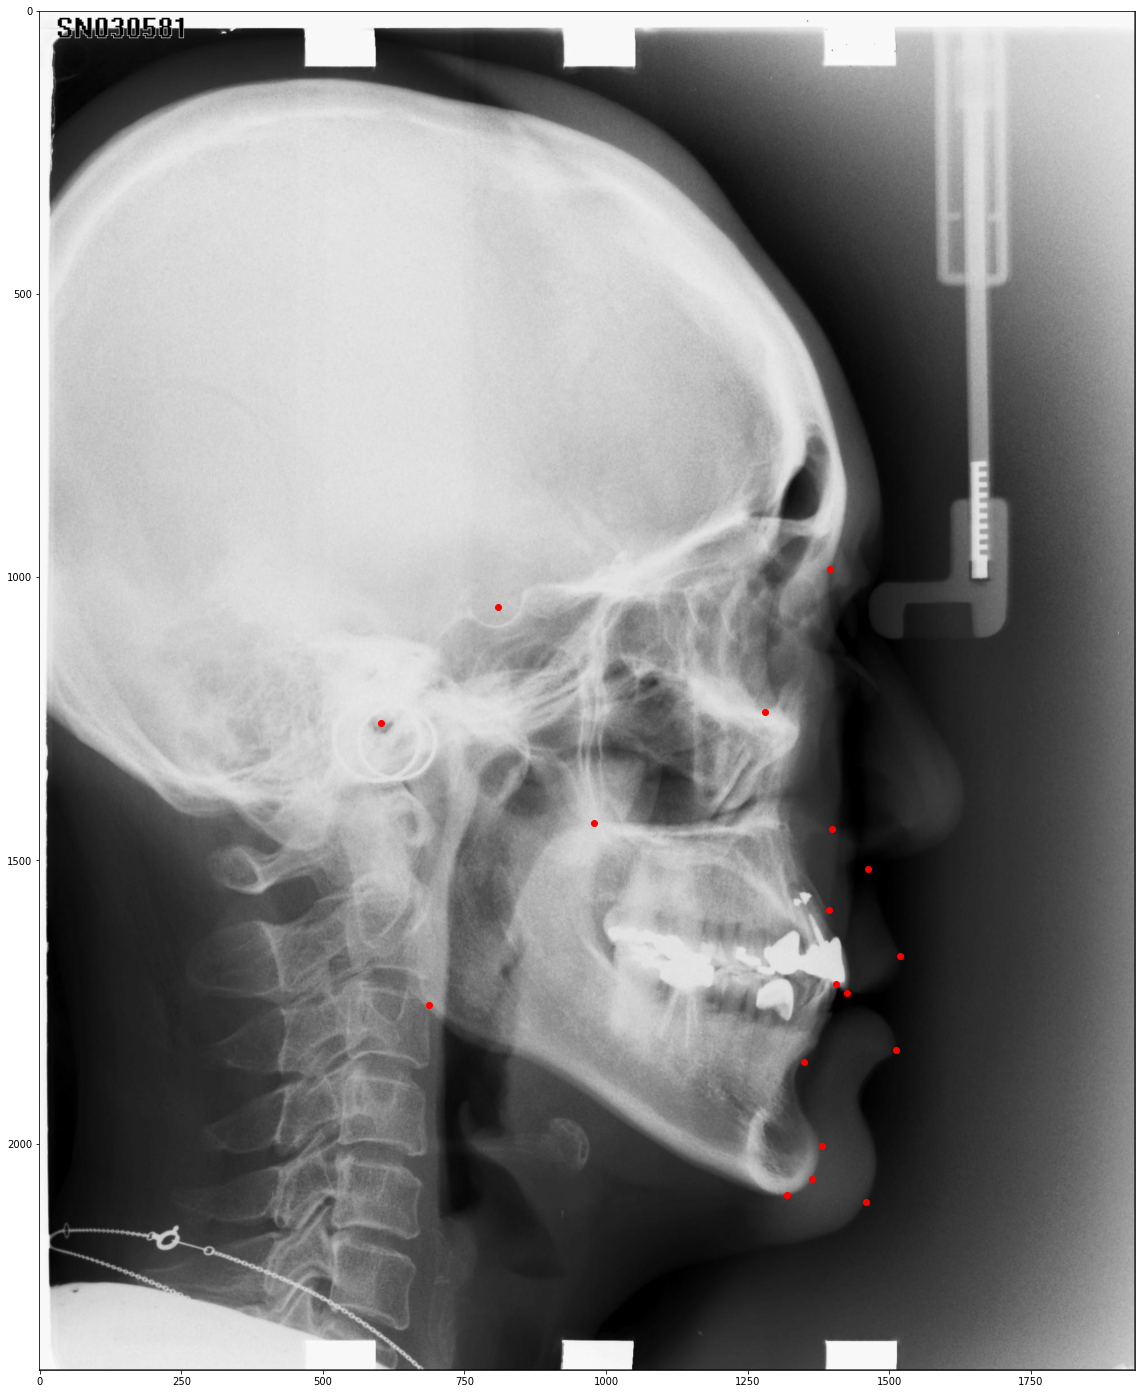

In [43]:
plot_sample_tensor(train,1)

In [50]:
random.randint(0, len(train))

91

In [52]:

num_epochs = 5
batch_size = 10
learning_rate = 0.0005

cnn = CNN()
torch.save(cnn.state_dict(), "aug_model_attempt.pth.tar")

cnn.load_state_dict(torch.load("aug_model_attempt.pth.tar"))



<All keys matched successfully>

In [54]:
# load in test set
TEST_AUG_BASE_PATH = r"./test"
test_set, test_set_loader = prep_train_loader(TEST_AUG_BASE_PATH)

In [58]:
# test cnn on some images from test set (change i or use random to swap views)
for i, (data, target) in enumerate(test_set_loader):
    if i == 1:
        test_batch = Variable(data)
        test_target = Variable(target)

test_target = test_target[0].data.numpy()*80+80
test_target = test_target.tolist()

def group(lst, n):
    # group list into consec tuples
    return zip(*[lst[i::n] for i in range(n)]) 


test_img = test_batch[0].data.numpy().squeeze()
prediction = cnn(test_batch)[0].data.numpy()*80+80
prediction = group(prediction, 2)

plt.imshow(test_img, cmap="gray")
plt.scatter(*zip(*test_target[:]), color="blue")
plt.scatter(*zip(*prediction[:]), color="red")
plt.show()

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 4441608960 bytes.